<h2>Importing External Packages</h2>



In [2]:
import sys
import warnings
import math

import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from imblearn.over_sampling import SMOTE

# Model components
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from keras import Sequential
from keras.layers import Dense
from keras.activations import relu, softmax, linear, sigmoid
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve

In [3]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

<h2>Exploratory Data Analysis</h2>

In [5]:
data = pd.read_csv(r"../data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.shape

(284807, 31)

In [7]:
data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
data_fraud = data[data['Class'] == 1]
data_not_fraud = data[data['Class'] == 0]
print(data_fraud.shape)
print(data_not_fraud.shape)

(492, 31)
(284315, 31)


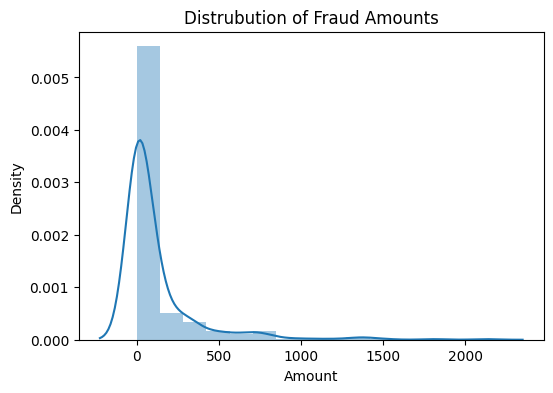

In [11]:
plt.figure(figsize=(6, 4))
sns.distplot(data_fraud['Amount'], kde=True, bins=15)
plt.title('Distrubution of Fraud Amounts')
plt.xlabel('Amount')
plt.show()

<p>Fraud classification can't be inferred from Amount as they are relatively close to non-fraud transactions</p>

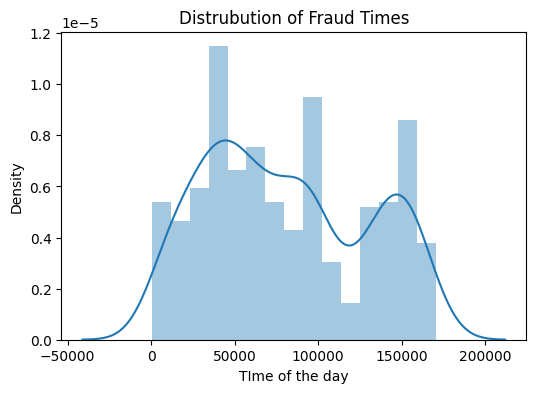

In [14]:
plt.figure(figsize=(6, 4))
sns.distplot(data_fraud['Time'], kde=True, bins=15)
plt.title('Distrubution of Fraud Times')
plt.xlabel('TIme of the day')
plt.show()

<p>Fraud classification can't be inferred from time as they don't occur at any specific time period of the day</p>

In [15]:
data.drop(['Time', 'Amount'], axis=1, inplace=True)

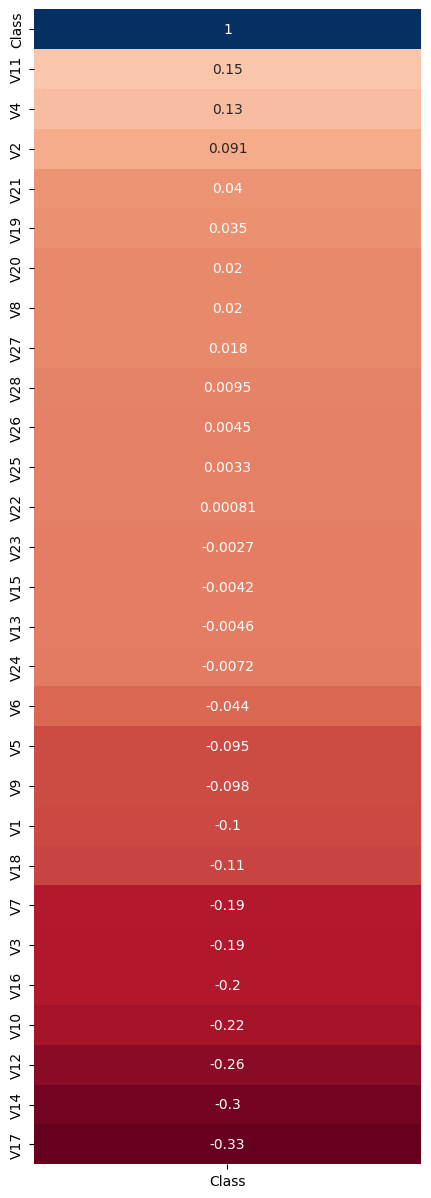

In [16]:
corr = data.corr()[['Class']].sort_values(by='Class', ascending=False)
plt.figure(figsize=(5, 15))
sns.heatmap(corr, annot=True, cbar=False, cmap='RdBu')
plt.show()

In [12]:
data_columns = data.columns.tolist()

In [13]:
data[data.columns[1:]].corr()['Class'][:-1].sort_values(ascending=False)

V11    0.154876
V4     0.133447
V2     0.091289
V21    0.040413
V19    0.034783
V20    0.020090
V8     0.019875
V27    0.017580
V28    0.009536
V26    0.004455
V25    0.003308
V22    0.000805
V23   -0.002685
V15   -0.004223
V13   -0.004570
V24   -0.007221
V6    -0.043643
V5    -0.094974
V9    -0.097733
V18   -0.111485
V7    -0.187257
V3    -0.192961
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64

<h2>Preprocessing the data</h2>

In [14]:
# dropping features loosely correlated with the target

to_drop = ['V28', 'V26', 'V25', 'V22', 'V23', 'V15', 'V13', 'V24', 'V8']
data.drop(to_drop, inplace=True, axis=1)

In [15]:
print("Number of columns remaining: ", data.shape[1])

Number of columns remaining:  20


In [16]:
# outlier removal

data_cpy = data.copy()

for i in [i for i in data.columns]:
    if data[i].nunique()>=12:
        Q1 = data[i].quantile(0.15)
        Q3 = data[i].quantile(0.85)
        IQR = Q3-Q1
        data = data[data[i] <= (Q3+(1.5*IQR))]
        data = data[data[i] >= (Q1-(1.5*IQR))]

In [17]:
x = data.drop('Class', axis=1)
y = data['Class']

In [18]:
# standard scaler

x_columns = x.columns.tolist()
sc = StandardScaler()
x_sc = sc.fit_transform(x)

In [19]:
x_sc = pd.DataFrame(x_sc, columns=x_columns)

In [20]:
# pipelining for feature selection

pip = Pipeline([('const', DropConstantFeatures()),
                ('corr', SmartCorrelatedSelection()),
                ('dup', DropDuplicateFeatures())])
x_pip = pip.fit_transform(x_sc)
x_pip.shape

(242824, 19)

In [21]:
# viewing the skewness of each column

x_columns_pip = x_pip.columns.tolist()
skew = []
for col in x_columns_pip:
    skew.append(stats.skew(x_pip[col]))
skew_table = tabulate({'Column': x_columns_pip, 
                       'Skew': skew },
                      tablefmt='fancy_grid',
                      headers=('keys'))
print(skew_table)

╒══════════╤════════════╕
│ Column   │       Skew │
╞══════════╪════════════╡
│ V1       │ -0.457842  │
├──────────┼────────────┤
│ V2       │ -0.193117  │
├──────────┼────────────┤
│ V3       │ -0.31361   │
├──────────┼────────────┤
│ V4       │  0.393778  │
├──────────┼────────────┤
│ V5       │  0.555007  │
├──────────┼────────────┤
│ V6       │  1.48543   │
├──────────┼────────────┤
│ V7       │  0.0221095 │
├──────────┼────────────┤
│ V9       │  0.103001  │
├──────────┼────────────┤
│ V10      │  0.255465  │
├──────────┼────────────┤
│ V11      │  0.0495084 │
├──────────┼────────────┤
│ V12      │ -0.990294  │
├──────────┼────────────┤
│ V14      │ -0.16644   │
├──────────┼────────────┤
│ V16      │ -0.407522  │
├──────────┼────────────┤
│ V17      │  0.5656    │
├──────────┼────────────┤
│ V18      │ -0.0147786 │
├──────────┼────────────┤
│ V19      │ -0.0496854 │
├──────────┼────────────┤
│ V20      │  0.614729  │
├──────────┼────────────┤
│ V21      │  0.150356  │
├──────────┼

In [22]:
# oversampling to counter imbalance

sm = SMOTE()
x_sm, y_sm = SMOTE().fit_resample(x_pip, y)

x_sm.shape, y_sm.shape

((485560, 19), (485560,))

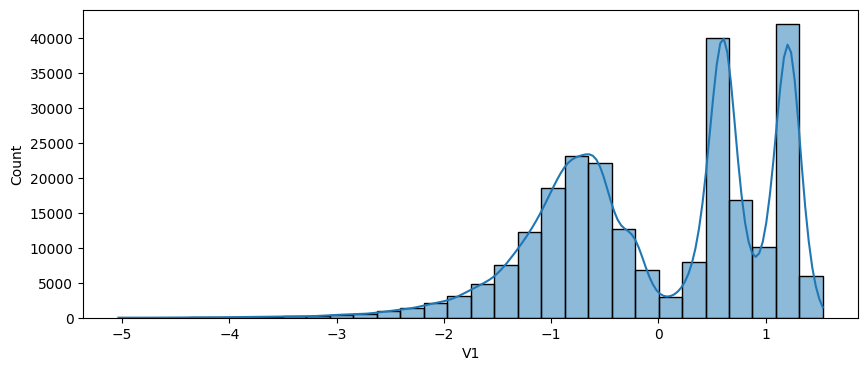

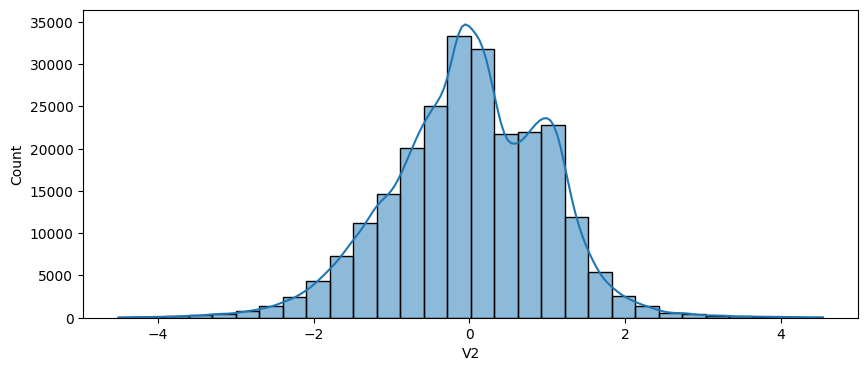

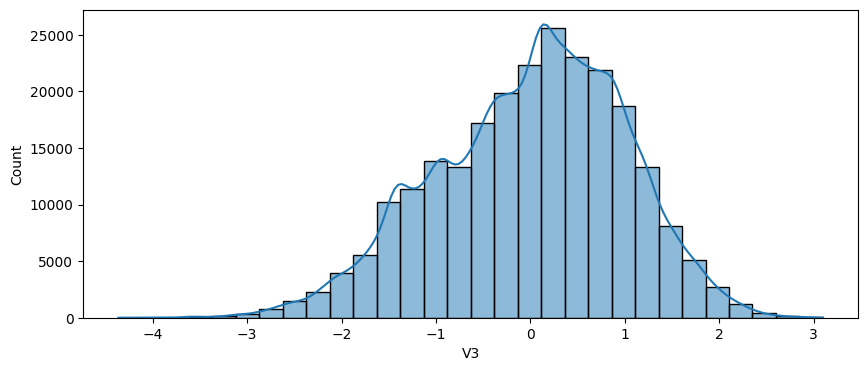

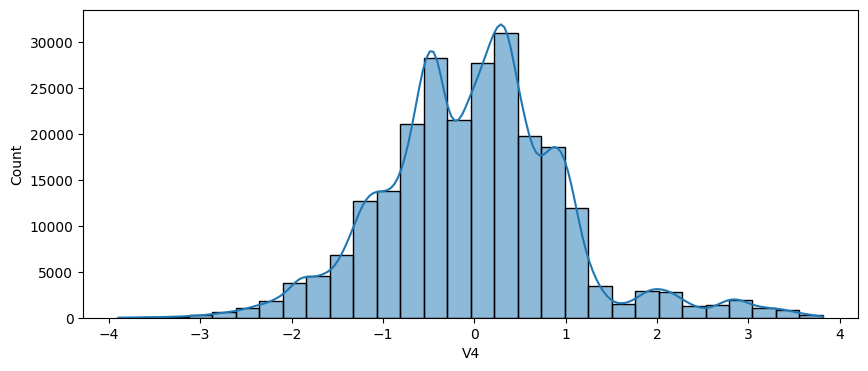

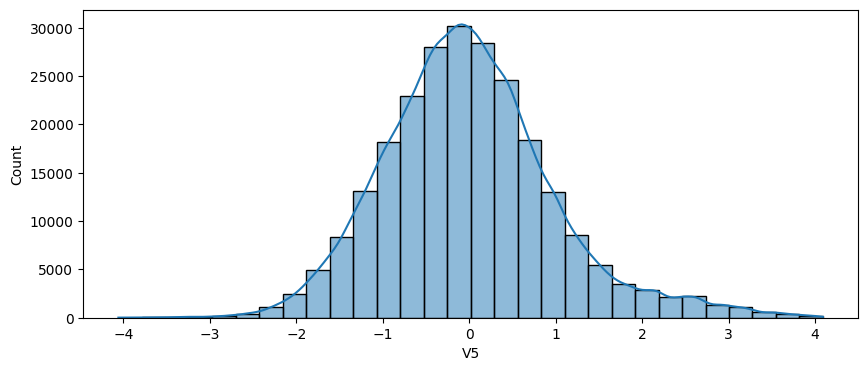

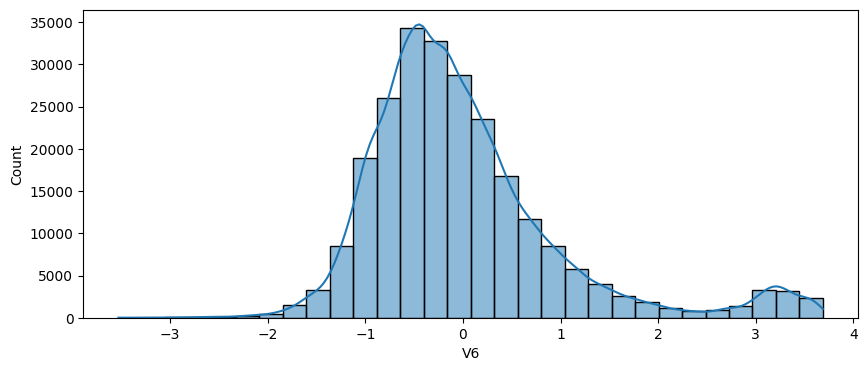

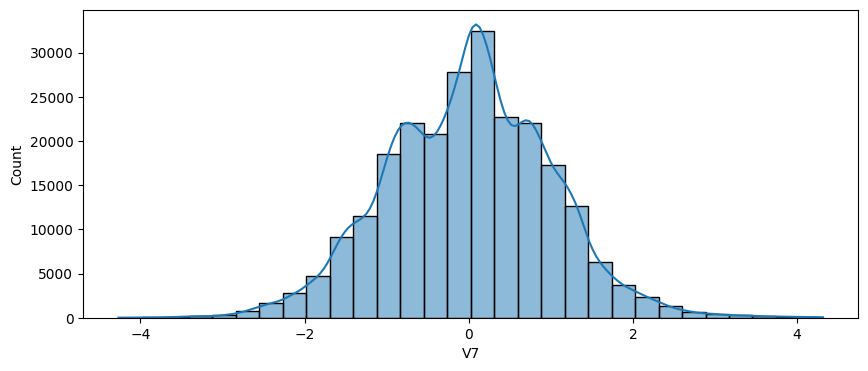

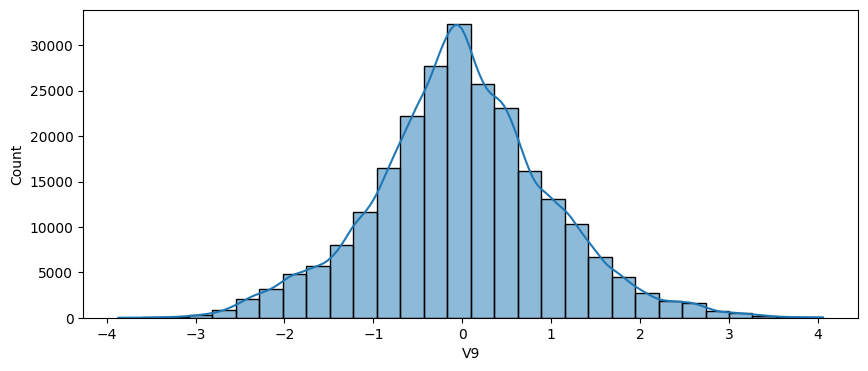

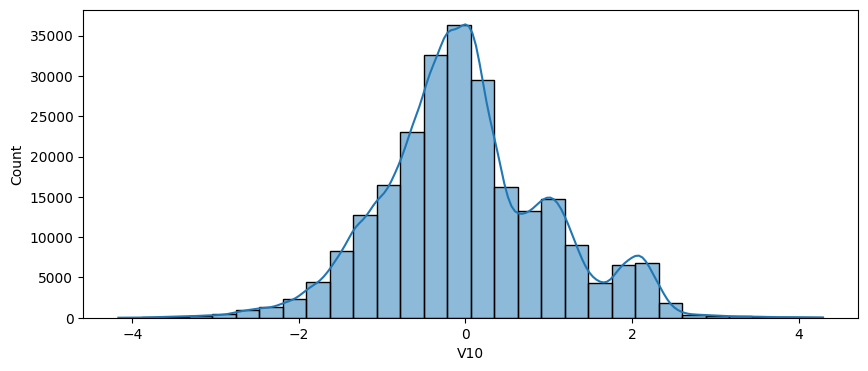

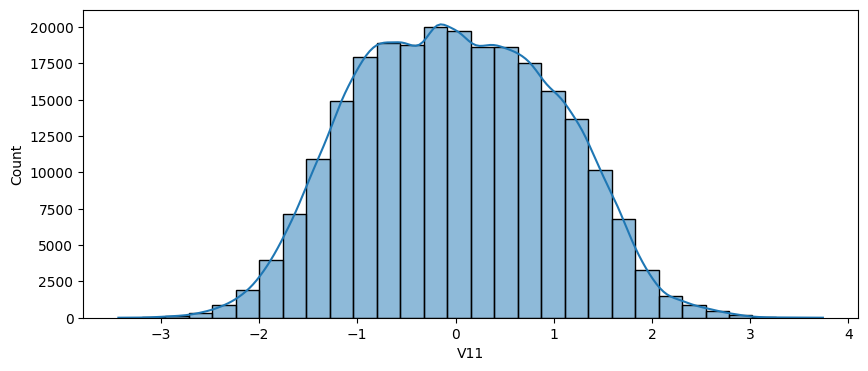

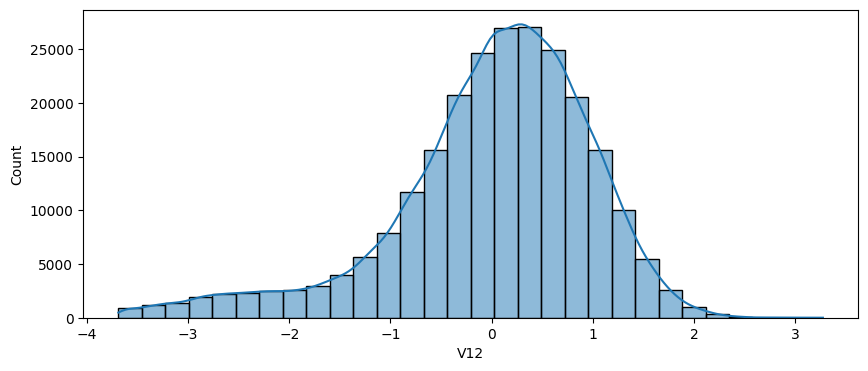

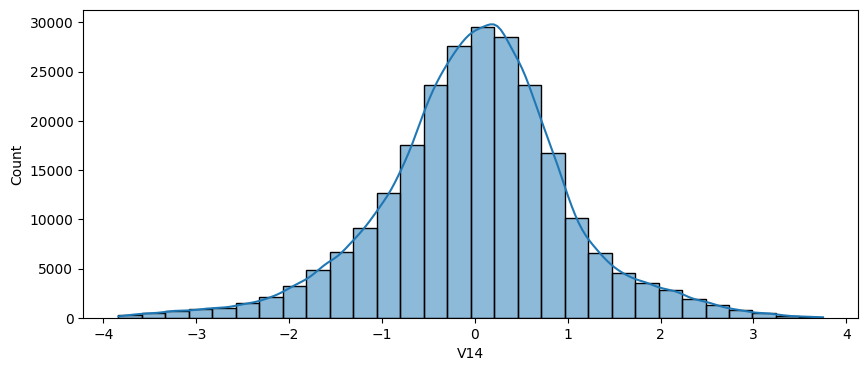

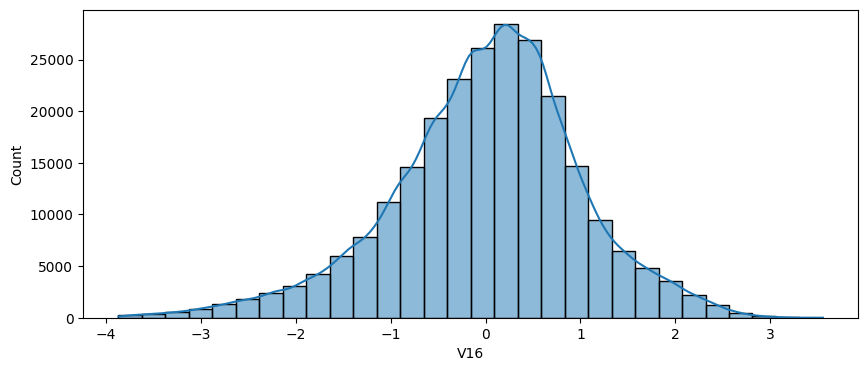

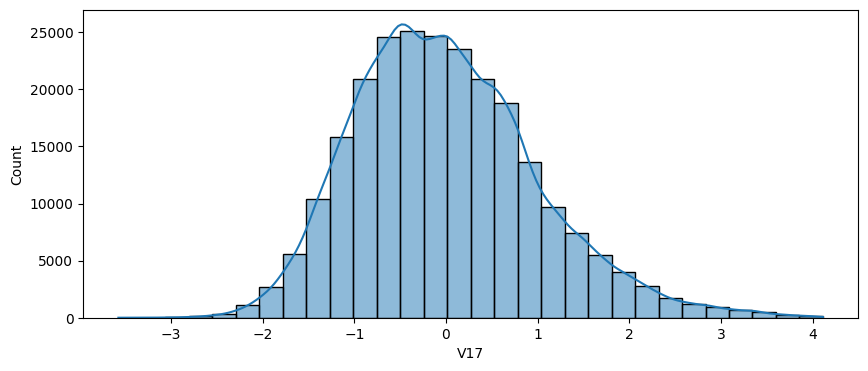

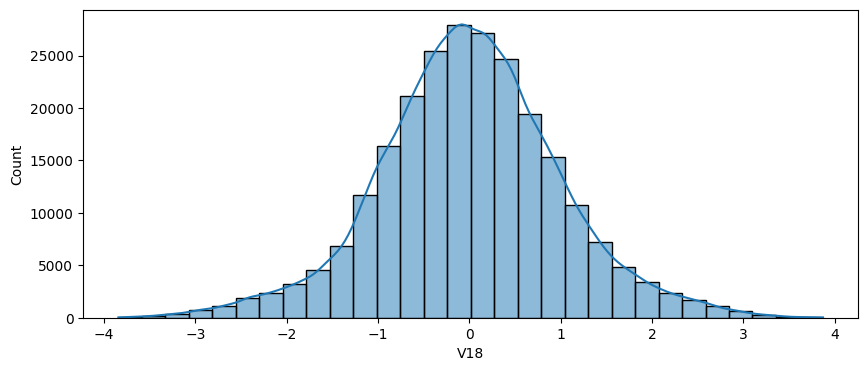

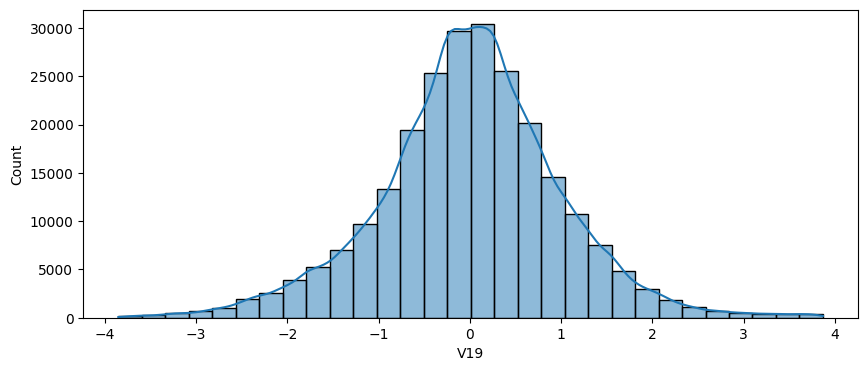

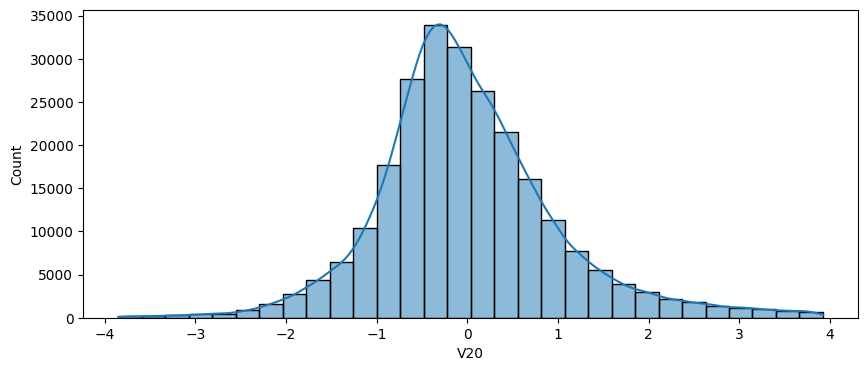

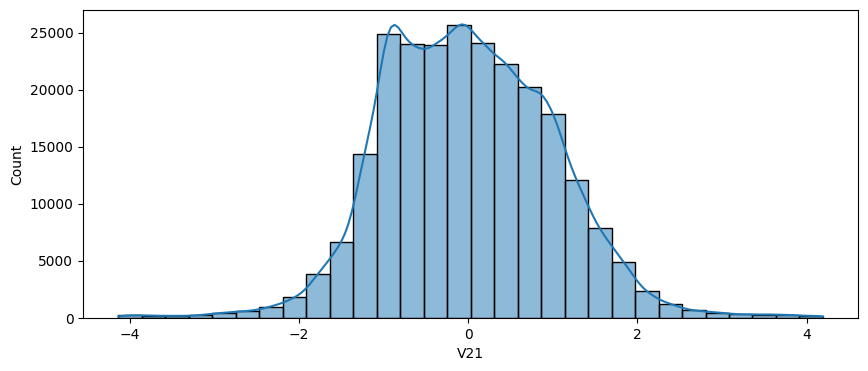

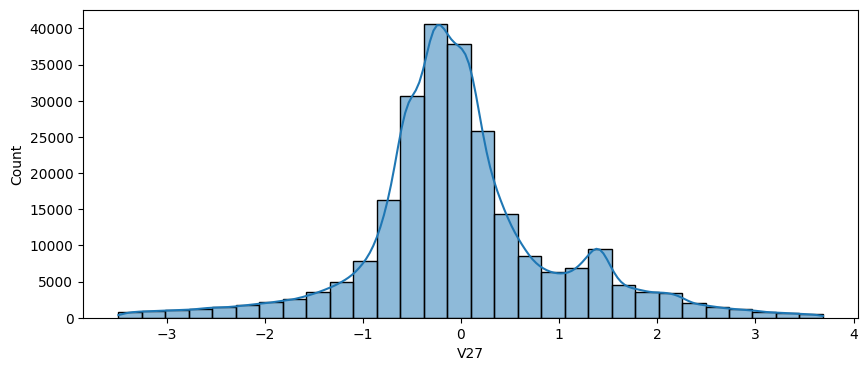

In [23]:
for col in x_columns_pip:
    plt.figure(figsize=(10, 4))
    sns.histplot(x_pip[col], kde=True, bins=30)
    plt.show()

<h2>Training and Testing the models</h2>

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, random_state=0)

<h4>1. Dense Neural Network</h4>

In [25]:
inp_shape = x_train.shape[1]
model_seq = Sequential([
    Dense(inp_shape, input_shape=(inp_shape, ), activation='relu', name='L1'),
    Dense(32, activation='relu', name='L2'),
    Dense(1, activation='sigmoid', name='L3')
], name='Sequential_Model')


model_seq.compile(
    loss = BinaryCrossentropy(from_logits=False),
    optimizer = Adam(0.009),
    metrics = ['accuracy']
)

In [26]:
model_seq.fit(x_train, y_train, epochs=10)

Epoch 1/10
12139/12139 [==============================] - 32s 3ms/step - loss: 0.0244 - accuracy: 0.9933
Epoch 2/10
12139/12139 [==============================] - 30s 3ms/step - loss: 0.0109 - accuracy: 0.9975
Epoch 3/10
12139/12139 [==============================] - 30s 2ms/step - loss: 0.0078 - accuracy: 0.9982
Epoch 4/10
12139/12139 [==============================] - 30s 2ms/step - loss: 0.0071 - accuracy: 0.9985
Epoch 5/10
12139/12139 [==============================] - 30s 2ms/step - loss: 0.0058 - accuracy: 0.9987
Epoch 6/10
12139/12139 [==============================] - 30s 2ms/step - loss: 0.0050 - accuracy: 0.9989
Epoch 7/10
12139/12139 [==============================] - 30s 3ms/step - loss: 0.0050 - accuracy: 0.9989
Epoch 8/10
12139/12139 [==============================] - 30s 3ms/step - loss: 0.0048 - accuracy: 0.9990
Epoch 9/10
12139/12139 [==============================] - 30s 3ms/step - loss: 0.0044 - accuracy: 0.9991
Epoch 10/10
12139/12139 [==============================

In [27]:
model_seq.summary()

Model: "Sequential_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 19)                380       
                                                                 
 L2 (Dense)                  (None, 32)                640       
                                                                 
 L3 (Dense)                  (None, 1)                 33        
                                                                 
Total params: 1,053
Trainable params: 1,053
Non-trainable params: 0
_________________________________________________________________


In [28]:
pred_seq = (model_seq.predict(x_test) > 0.5).astype("int32")

3035/3035 [==============================] - 6s 2ms/step


In [29]:
test_loss, test_accuracy = model_seq.evaluate(x_test, y_test)
print("Testing Accuracy: ", test_accuracy)

3035/3035 [==============================] - 7s 2ms/step - loss: 0.0025 - accuracy: 0.9995
Testing Accuracy:  0.9994954466819763


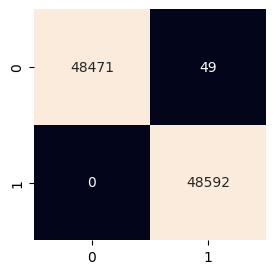

In [30]:
plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix(y_test, pred_seq), annot=True, fmt='d', cbar=False)
plt.show()

In [31]:
print("Precision Score: ", precision_score(y_test, pred_seq))
print("Recall Score   : ", recall_score(y_test, pred_seq))
print("F1 Score       : ", f1_score(y_test, pred_seq))

Precision Score:  0.9989926193951605
Recall Score   :  1.0
F1 Score       :  0.9994960558658069


<h4>2. Multi-Layer Perceptron Classifier (ANN)</h4>

In [32]:
model_mlp = MLPClassifier(hidden_layer_sizes=(32,))
model_mlp.fit(x_train, y_train)
pred_mlp = model_mlp.predict(x_test)
print("Testing Accuracy: ", accuracy_score(y_test, pred_mlp))

Testing Accuracy:  0.9996292940110388


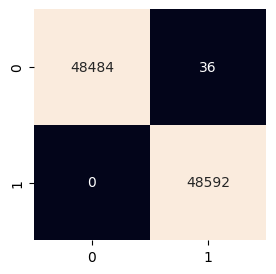

In [33]:
plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix(y_test, pred_mlp), annot=True, fmt='d', cbar=False)
plt.show()

In [34]:
print("Precision Score: ", precision_score(y_test, pred_mlp))
print("Recall Score   : ", recall_score(y_test, pred_mlp))
print("F1 Score       : ", f1_score(y_test, pred_mlp))

Precision Score:  0.9992596857777413
Recall Score   :  1.0
F1 Score       :  0.9996297058218474


<h4>3. Random Forest Classifier</h4>

In [35]:
model_rfc = RandomForestClassifier(n_estimators=20)
model_rfc.fit(x_train, y_train)
pred_rfc = model_rfc.predict(x_test)
print("Testing Accuracy: ", accuracy_score(y_test, pred_rfc))

Testing Accuracy:  0.9998661339484307


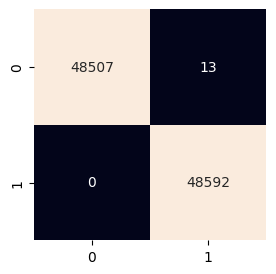

In [36]:
plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix(y_test, pred_rfc), annot=True, fmt='d', cbar=False)
plt.show()

In [37]:
print("Precision Score: ", precision_score(y_test, pred_rfc))
print("Recall Score   : ", recall_score(y_test, pred_rfc))
print("F1 Score       : ", f1_score(y_test, pred_rfc))

Precision Score:  0.9997325378047526
Recall Score   :  1.0
F1 Score       :  0.9998662510159778


<h3>ROC Curve comparison</h3>

In [ ]:
fpr_seq, tpr_seq, _ = metrics.roc_curve(y_test,  pred_seq)

plt.plot(fpr_seq, tpr_seq)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()